# Data_Prep

In [1]:
raw_dict = { 
    # collected from https://becomeanutritionist.org/blog/types-of-diets/#elementor-toc__heading-anchor-13
    "Balanced Diet": {
        "recommended": [],
        "avoids": []
    },
    "Keto Diet": {
        "recommended": ["Meat", "Fatty fish", "Eggs", "Cheese", "Butter", "Nuts", "Oils", "Low-carb vegetables"],
        "avoids": ["Grains", "Sugar", "High-carb fruits", "Legumes"]
    },
    "Paleo Diet": {
        "recommended": ["Meat", "Fish", "Fruits", "Vegetables", "Nuts", "Seeds"],
        "avoids": ["Dairy", "Grains", "Legumes", "Processed foods", "Sugar"]
    },
    "Vegetarian Diet": {
        "recommended": ["Vegetables", "Fruits", "Grains", "Dairy", "Eggs"],
        "avoids": ["Meat"]
    },
    "Vegan Diet": {
        "recommended": ["Fruits", "Vegetables", "Grains", "Legumes", "Nuts", "Seeds"],
        "avoids": ["All animal-derived products"]
    },
    "Mediterranean Diet": {
        "recommended": ["Olive oil", "Fish", "Fruits", "Vegetables", "Legumes", "Nuts", "Whole grains"],
        "avoids": ["Red meat", "Refined grains", "Processed foods"]
    },
    "Intermittent Fasting Diet": {
        "recommended": [],
        "avoids": []
    },
    "Low-Carb Diet": {
        "recommended": ["Meat", "Fish", "Eggs", "Vegetables", "Nuts", "Seeds"],
        "avoids": ["Grains", "Starchy vegetables", "Sugars"]
    },
    "DASH Diet": {
        "recommended": ["Fruits", "Vegetables", "Whole grains", "Lean protein", "Low-fat dairy"],
        "avoids": ["High sodium foods", "Sugary drinks", "Red meat"]
    },
    "MIND Diet": {
        "recommended": ["Leafy greens", "Berries", "Nuts", "Olive oil", "Whole grains", "Fish"],
        "avoids": ["Red meat", "Butter", "Cheese", "Pastries", "Fried food"]
    },
    "Flexitarian Diet": {
        "recommended": ["Vegetables", "Fruits", "Whole grains", "Legumes", "Some meat"],
        "avoids": ["Highly processed foods"]
    },
    "Raw Food Diet": {
        "recommended": ["Fruits", "Vegetables", "Nuts", "Seeds", "Raw grains", "Legumes"],
        "avoids": ["Cooked or processed foods", "Refined sugars", "Oils"]
    },
    "Carnivore Diet": {
        "recommended": ["Meat", "Fish", "Eggs", "Animal fats"],
        "avoids": ["Fruits", "Vegetables", "Grains", "Legumes"]
    },
    "Whole30 Diet": {
        "recommended": ["Meat", "Seafood", "Vegetables", "Fruits", "Some fats"],
        "avoids": ["Sugar", "Grains", "Dairy", "Alcohol", "Legumes", "Processed foods"]
    },
    "Zone Diet": {
        "recommended": ["Lean proteins", "Healthy fats", "Low-glycemic carbs"],
        "avoids": ["Refined carbs", "Sugary snacks", "Processed foods"]
    }
}


In [2]:
triples = []

for diet, food_dict in raw_dict.items():
    for food in food_dict.get("recommended", []):
        triples.append((diet.lower(), food.lower(), 1))
    for food in food_dict.get("avoids", []):
        triples.append((diet.lower(), food.lower(), -1))

In [3]:
# handling speacial cases
foods = ["Meat", "Fatty fish", "fish", "Eggs", "Cheese", "Butter", "Nuts", "Oils", "Low-carb vegetables"
        "Grains", "whole grains", "Sugar", "High-carb fruits", "Legumes", "Lean proteins", "Healthy fats", "Low-glycemic carbs"]
for food in foods:
    triples.append(("Balanced Diet".lower(), food.lower(), 1))
    triples.append(("Intermittent Fasting Diet".lower(), food.lower(), 1))


In [4]:

from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import torch.nn.functional as F


/workspace/shukaic/miniconda3/envs/sml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Load pre-trained BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

2025-03-31 00:04:28.962905: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
print(len(triples))

146


In [92]:
print(triples)

[('keto diet', 'meat', 1), ('keto diet', 'fatty fish', 1), ('keto diet', 'eggs', 1), ('keto diet', 'cheese', 1), ('keto diet', 'butter', 1), ('keto diet', 'nuts', 1), ('keto diet', 'oils', 1), ('keto diet', 'low-carb vegetables', 1), ('keto diet', 'grains', -1), ('keto diet', 'sugar', -1), ('keto diet', 'high-carb fruits', -1), ('keto diet', 'legumes', -1), ('paleo diet', 'meat', 1), ('paleo diet', 'fish', 1), ('paleo diet', 'fruits', 1), ('paleo diet', 'vegetables', 1), ('paleo diet', 'nuts', 1), ('paleo diet', 'seeds', 1), ('paleo diet', 'dairy', -1), ('paleo diet', 'grains', -1), ('paleo diet', 'legumes', -1), ('paleo diet', 'processed foods', -1), ('paleo diet', 'sugar', -1), ('vegetarian diet', 'vegetables', 1), ('vegetarian diet', 'fruits', 1), ('vegetarian diet', 'grains', 1), ('vegetarian diet', 'dairy', 1), ('vegetarian diet', 'eggs', 1), ('vegetarian diet', 'meat', -1), ('vegan diet', 'fruits', 1), ('vegan diet', 'vegetables', 1), ('vegan diet', 'grains', 1), ('vegan diet', '

In [32]:
# Map: (diet, food) -> (index, label)
triple_index_map = {(d.lower(), f.lower()): i for i, (d, f, _) in enumerate(triples)}

In [91]:
# print(triple_index_map)

In [7]:
batch_size = len(triples)
dim = 768
phi_d = torch.empty(batch_size, dim)
phi_n = torch.empty(batch_size, dim)
y = torch.empty(batch_size, 1)

In [44]:
print(phi_d.shape)

torch.Size([146, 768])


In [9]:

for i, triple in enumerate(triples):
    diet, food, label = triple
    diet_embed = tokenizer(diet, return_tensors="pt")
    food_embed = tokenizer(food, return_tensors="pt")

    # Get model outputs (embeddings for each token)
    with torch.no_grad():
        outputs = model(**diet_embed)
        embeddings = outputs.last_hidden_state # shape: [1, sequence_len, hidden_dim]
        phi_d[i, :] = embeddings[0, 0]  # get CLS token embedding


    with torch.no_grad():
        outputs = model(**food_embed)
        embeddings = outputs.last_hidden_state
        phi_n[i, :] = embeddings[0, 0]  # get CLS token embedding
        
    y[i] = label

# torch.save(phi_d, "bert_phi_d.pt")
# torch.save(phi_n, "bert_phi_n.pt")
# torch.save(y, "y.pt")

# trainable param: W1, W2
# constrastive loss


## Build a trainable model for projection from high-dimensional to low-dimensional space

In [10]:
class DietFoodContrastiveModel(nn.Module):
    def __init__(self, in_dim=768, proj_dim=128):
        super().__init__()
        
        self.proj_d = nn.Sequential(
            # nn.Linear(in_dim, 512), ##
            # nn.ReLU(), ## add
            nn.Linear(in_dim, proj_dim),
            # nn.LayerNorm(proj_dim), ## 
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )
        
        self.proj_n = nn.Sequential(
            # nn.Linear(in_dim, 512), ##
            # nn.ReLU(), ## add
            nn.Linear(in_dim, proj_dim),
            # nn.LayerNorm(proj_dim), ## 
            nn.ReLU(),
            nn.Linear(proj_dim, proj_dim)
        )

    def forward(self, phi_d, phi_n):
        z_d = self.proj_d(phi_d)
        z_n = self.proj_n(phi_n)
        return z_d, z_n

In [11]:
def cosine_contrastive_loss(phi_r, phi_v, y, alpha=0.5):
    """
    phi_r: tensor of shape (batch_size, dim)
    phi_v: tensor of shape (batch_size, dim)
    y: tensor of shape (batch_size,) with values 1 or -1
    alpha: margin value
    """
    # Cosine similarity (normalized)
    cos_sim = F.cosine_similarity(phi_r, phi_v, dim=-1)  # shape: (batch_size,)

    # Positive loss: 1 - cosine similarity
    pos_loss = 1 - cos_sim

    # Negative loss: max(0, cosine similarity - alpha)
    neg_loss = F.relu(cos_sim - alpha)

    # Combine losses based on labels
    loss = torch.where(y == 1, pos_loss, neg_loss)

    return loss.mean()

In [12]:
# phi_d = torch.load("bert_phi_d.pt")
# phi_n = torch.load("bert_phi_n.pt")
# y = torch.load("y.pt").squeeze()  # Make sure shape is (batch_size,)
y = y.squeeze()

# Just in case label isn't tensor of dtype float or long
y = y.to(phi_d.device).long()  # ensure same device, long dtype for indexing in torch.where

In [13]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(phi_d, phi_n, y)
batch_size = 64 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
# Train model
model_DietFoodContrastiveModel = DietFoodContrastiveModel()
optimizer = torch.optim.Adam(model_DietFoodContrastiveModel.parameters(), lr=1e-6)
epochs = 10000

loss_list = []

# for epoch in range(epochs):
#     model.train()
#     z_d, z_n = model(phi_d, phi_n)
    
#     loss = cosine_contrastive_loss(z_d, z_n, y, alpha=0.5)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     loss_list.append(loss.item())
#     # print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

for epoch in range(epochs):
    model_DietFoodContrastiveModel .train()
    epoch_loss = 0

    for batch_phi_d, batch_phi_n, batch_y in dataloader:
        batch_phi_d = batch_phi_d.to(phi_d.device)
        batch_phi_n = batch_phi_n.to(phi_d.device)
        batch_y = batch_y.to(phi_d.device)

        z_d, z_n = model_DietFoodContrastiveModel (batch_phi_d, batch_phi_n)
        loss = cosine_contrastive_loss(z_d, z_n, batch_y, alpha=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    loss_list.append(avg_loss)

In [19]:
import matplotlib.pyplot as plt

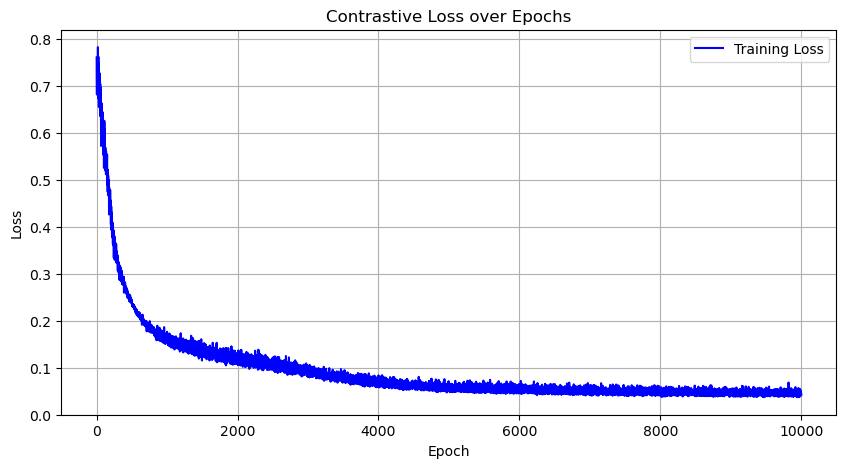

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(loss_list, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

In [21]:
from sklearn.manifold import TSNE
import numpy as np

In [22]:
model_DietFoodContrastiveModel .eval()


DietFoodContrastiveModel(
  (proj_d): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (proj_n): Sequential(
    (0): Linear(in_features=768, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
)

In [83]:
with torch.no_grad():
    z_d, z_n = model_DietFoodContrastiveModel (phi_d, phi_n)

In [103]:
torch.save(model_DietFoodContrastiveModel.state_dict(), "diet_food_contrastive_model.pth")

# Checking

In [67]:
import torch.nn.functional as F

def check_model_prediction(diet_name, food_list, triples, z_d, z_n, y):
    triple_index_map = {
        (d.lower(), f.lower()): i for i, (d, f, _) in enumerate(triples)
    }

    similarities = {}
    labels = {}

    for food in food_list:
        key = (diet_name.lower(), food.lower())
        if key not in triple_index_map:
            print(f"Skip: ({diet_name}, {food}) not in triples.")
            continue

        idx = triple_index_map[key]
        zd = z_d[idx].unsqueeze(0)  # [1, proj_dim]
        zn = z_n[idx].unsqueeze(0)
        sim = F.cosine_similarity(zd, zn).item()

        similarities[food] = sim
        labels[food] = y[idx].item()

    return similarities, labels


In [102]:
diet = "Keto Diet"
foods = [
    "Meat", "Fatty fish", "Eggs", "Cheese", "Butter", "Low-carb vegetables",  # recommend
    "Grains", "Sugar", "High-carb fruits", "Legumes", "Rice",                 # avoid
]

# diet = "Vegan Diet"
# foods = [
#     "Fruits", "Vegetables", "Grains", "Legumes", "Nuts", "Seeds",           # recommend
#     "Cheese", "Eggs", "Meat", "Fish", "Butter", "Milk",                      # avoid
# ]


# diet = "Carnivore Diet"
# foods = [
#     "Meat", "Fish", "Eggs", "Animal fats",                                   # recommend
#     "Fruits", "Vegetables", "Legumes", "Oats", "Whole grains",               # avoid
# ]

# diet = "Mediterranean Diet"
# foods = [
#     "Olive oil", "Fish", "Fruits", "Vegetables", "Legumes", "Whole grains",  # recommend
#     "Red meat", "Refined grains", "Processed foods", "Butter", "Soda"        # avoid
# ]

similarities, labels = check_model_prediction(diet, foods, triples, z_d, z_n, y)
# similarities, labels = check_model_prediction(diet, foods, triples, phi_d, phi_n, y)

print(f"\nModel prediction for {diet}:")
for food in sorted(similarities, key=lambda x: -similarities[x]):
    print(f"{food:15s}  |  Cosine sim: {similarities[food]:.4f}  |  Label: {labels[food]}")


Skip: (Keto Diet, Rice) not in triples.

Model prediction for Keto Diet:
Meat             |  Cosine sim: 0.9912  |  Label: 1
Cheese           |  Cosine sim: 0.9781  |  Label: 1
Fatty fish       |  Cosine sim: 0.9674  |  Label: 1
Eggs             |  Cosine sim: 0.9628  |  Label: 1
Low-carb vegetables  |  Cosine sim: 0.9581  |  Label: 1
Butter           |  Cosine sim: 0.9438  |  Label: 1
High-carb fruits  |  Cosine sim: 0.7550  |  Label: -1
Legumes          |  Cosine sim: 0.6719  |  Label: -1
Sugar            |  Cosine sim: 0.5002  |  Label: -1
Grains           |  Cosine sim: 0.4861  |  Label: -1
